In [130]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [131]:
# %pip install quantstats

In [132]:
# %pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym

In [133]:
# %pip install "gym==0.19.0"

In [134]:
# %pip install gym[all]

In [135]:
# %conda install -c conda-forge ta-lib

In [136]:
# %pip install yfinance

In [137]:
# %pip install protobuf==3.20.0

In [138]:
# %pip install stable-baselines3

In [139]:
# %pip install shimmy

In [140]:
# %pip install gymnasium

In [141]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import tensorflow as tf

In [142]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [143]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv
# from gymnasium import GymEnvironment

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, DQN, TD3, DDPG
# from stable_baselines.common.vec_env import DummyVecEnv
# from stable_baselines import A2C, DQN, TD3

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#Finance libraries
import datetime as dt
import talib as ta
import quantstats as qs

In [144]:
df = pd.read_csv("D:/Code/tickers.csv")
df = df[df.tic == "^TNX"]
df = df.drop(["Unnamed: 0", "tic", "day"], axis=1)
df = df.rename(columns = {'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})

In [145]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_values('date', ascending=True, inplace=True)

In [146]:
df['SMA_5'] = ta.SMA(df['Close'], 5)
df['SMA_14'] = ta.SMA(df['Close'], 14)
df['SMA_22'] = ta.SMA(df['Close'], 22)
# df['SMA_41'] = ta.SMA(df['Close'], 41)
# df['SMA_63'] = ta.SMA(df['Close'], 63)
df['EMA_5'] = ta.EMA(df['Close'], 5)
df['EMA_14'] = ta.EMA(df['Close'], 14)
df['EMA_22'] = ta.EMA(df['Close'], 22)
# df['EMA_41'] = ta.EMA(df['Close'], 41)
# df['EMA_63'] = ta.EMA(df['Close'], 63)
df['RSI'] = ta.RSI(df['Close'])
df['MACD'], df['MACD_SIGNAL'], df['MACD_HIST'] = ta.MACD(df['Close'])
df['BBANDS_UPPER'], df['BBANDS_MIDDLE'], df['BBANDS_LOWER'] = ta.BBANDS(df['Close'])
df['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'])
df['OBV'] = ta.OBV(df['Close'], df['Volume'])
df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'])

In [147]:
df.isnull().sum()

Open              0
High              0
Low               0
Close             0
Volume            0
SMA_5             4
SMA_14           13
SMA_22           21
EMA_5             4
EMA_14           13
EMA_22           21
RSI              14
MACD             33
MACD_SIGNAL      33
MACD_HIST        33
BBANDS_UPPER      4
BBANDS_MIDDLE     4
BBANDS_LOWER      4
ADX              27
OBV               0
ATR              14
dtype: int64

In [148]:
df.fillna(0, inplace=True)

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5727 entries, 2000-01-04 to 2023-09-19
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           5727 non-null   float64
 1   High           5727 non-null   float64
 2   Low            5727 non-null   float64
 3   Close          5727 non-null   float64
 4   Volume         5727 non-null   int64  
 5   SMA_5          5727 non-null   float64
 6   SMA_14         5727 non-null   float64
 7   SMA_22         5727 non-null   float64
 8   EMA_5          5727 non-null   float64
 9   EMA_14         5727 non-null   float64
 10  EMA_22         5727 non-null   float64
 11  RSI            5727 non-null   float64
 12  MACD           5727 non-null   float64
 13  MACD_SIGNAL    5727 non-null   float64
 14  MACD_HIST      5727 non-null   float64
 15  BBANDS_UPPER   5727 non-null   float64
 16  BBANDS_MIDDLE  5727 non-null   float64
 17  BBANDS_LOWER   5727 non-null   flo

Window_Size için 35 çünkü MACD kendinden önceki 33 gün kullanıyor. Bu sebeple window_size > 33 olmalı diye düşündüm. Çok büyük window_size olmasın diye 41 ve 63 günlük indicatörleri iptal ettim.

In [150]:
window_size = 35
start_index = window_size
end_train_index = round(len(df)*0.70)
end_val_index = len(df)

In [151]:
# Define the number of episodes for training
Time_Step = 1000000
# models_dir = 'D:/Code/Stock/Python/Stock/models/DQN_1'
logdir = 'D:/Code/Stock/Python/Stock/logs/'

# if not os.path.exists(models_dir):
#     os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [152]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    # signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'EMA', 'RSI', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ADX', 'OBV', 'ATR']].to_numpy()[start:end]
    # signal_features = env.df.loc[:, ['Low', 'Volume', 'SMA_5', 'SMA_14', 'SMA_22', 'SMA_41', 'SMA_63',
    #                                 'EMA_5', 'EMA_14', 'EMA_22', 'EMA_41', 'EMA_63', 'RSI', 'MACD', 'MACD_SIGNAL',
    #                                 'MACD_HIST', 'BBANDS_UPPER', 'BBANDS_MIDDLE', 'BBANDS_LOWER', 'ADX', 'OBV', 'ATR']].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume', 'SMA_5', 'SMA_14', 'SMA_22',
                                    'EMA_5', 'EMA_14', 'EMA_22', 'RSI', 'MACD', 'MACD_SIGNAL',
                                    'MACD_HIST', 'BBANDS_UPPER', 'BBANDS_MIDDLE', 'BBANDS_LOWER', 'ADX', 'OBV', 'ATR']].to_numpy()[start:end]
    return prices, signal_features

In [153]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env_custom = MyCustomEnv(df=df, window_size=window_size, frame_bound=(start_index,end_train_index))

In [154]:
env_maker = lambda: env_custom
env = DummyVecEnv([env_maker])

d:\Env\StockReinLearVenv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:50: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  "You provided an OpenAI Gym environment. "


In [155]:
model = DQN('MlpPolicy', env, verbose=1 ,tensorboard_log=logdir)
model.learn(total_timesteps=Time_Step)

Using cpu device


d:\Env\StockReinLearVenv\lib\site-packages\stable_baselines3\common\buffers.py:230: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 10.10GB > 1.52GB
  "This system does not have apparently enough memory to store the complete "


Logging to D:/Code/Stock/Python/Stock/logs/DQN_5
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.849    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2353     |
|    time_elapsed     | 6        |
|    total_timesteps  | 15892    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.698    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3594     |
|    time_elapsed     | 8        |
|    total_timesteps  | 31784    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.547    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 4445     |
|    time_elapsed     | 10       |
|    total_timesteps  | 47676    |
----------------------------------
------

In [156]:
env = MyCustomEnv(df=df, window_size=window_size, frame_bound=(end_train_index,end_val_index))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 2.1030002236366276, 'total_profit': 1.45841168008702, 'position': 1}


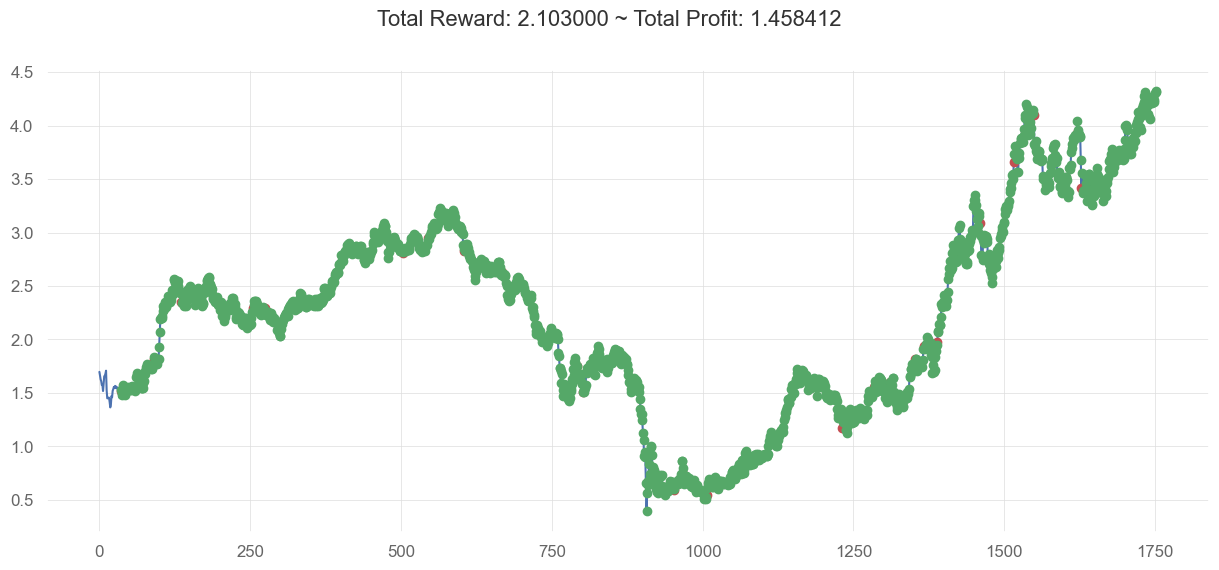

In [157]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

                           Strategy
-------------------------  ----------
Start Period               2016-08-04
End Period                 2023-09-19
Risk-Free Rate             0.0%
Time in Market             3.0%

Cumulative Return          45.84%
CAGR﹪                     3.72%

Sharpe                     0.35
Prob. Sharpe Ratio         86.9%
Smart Sharpe               0.35
Sortino                    0.77
Smart Sortino              0.77
Sortino/√2                 0.54
Smart Sortino/√2           0.54
Omega                      1.75

Max Drawdown               -83.46%
Longest DD Days            1749
Volatility (ann.)          66.48%
Calmar                     0.04
Skew                       19.97
Kurtosis                   739.4

Expected Daily %           0.02%
Expected Monthly %         0.44%
Expected Yearly %          4.83%
Kelly Criterion            24.8%
Risk of Ruin               0.0%
Daily Value-at-Risk        -6.8%
Expected Shortfall (cVaR)  -6.8%

Max Consecutive Wins       1


None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-12-06,2020-08-10,2023-09-19,1749,-83.458975,-82.824799
2,2017-07-03,2017-07-31,2018-02-22,235,-6.309043,-4.994094
3,2018-07-06,2018-07-06,2018-11-21,139,-2.190902,-0.305188
4,2016-08-22,2016-08-22,2016-10-13,53,-1.108703,NaN


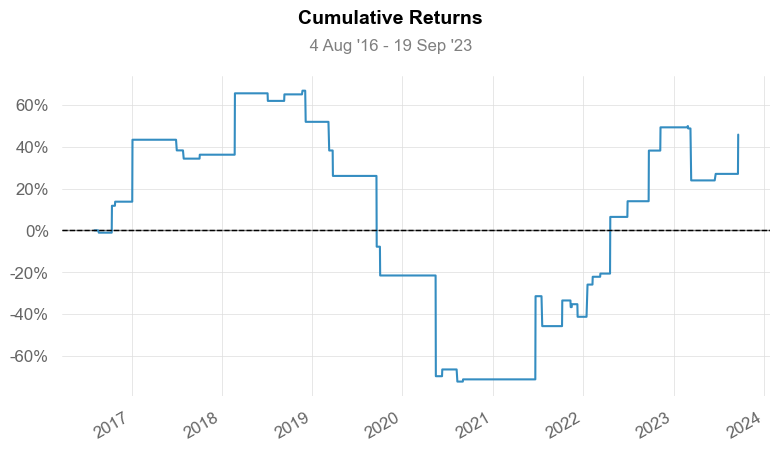

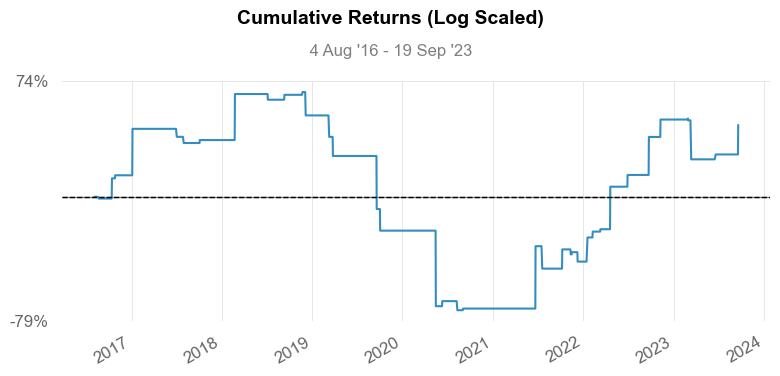

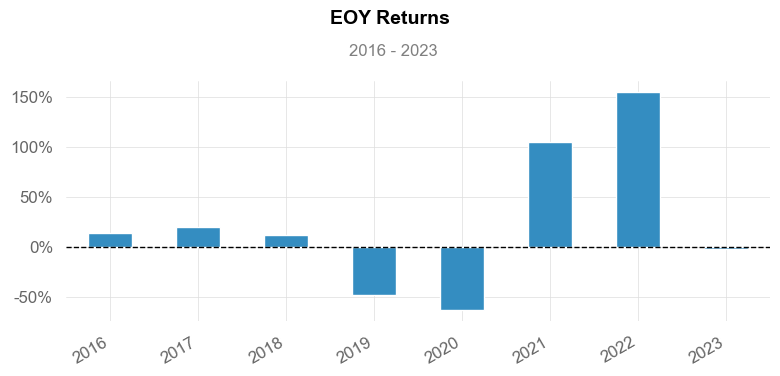

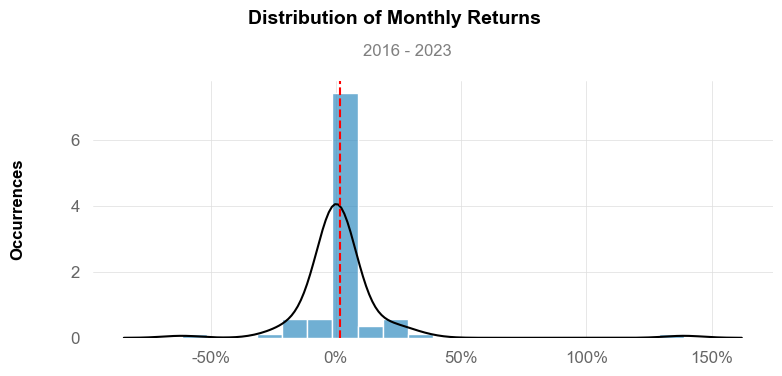

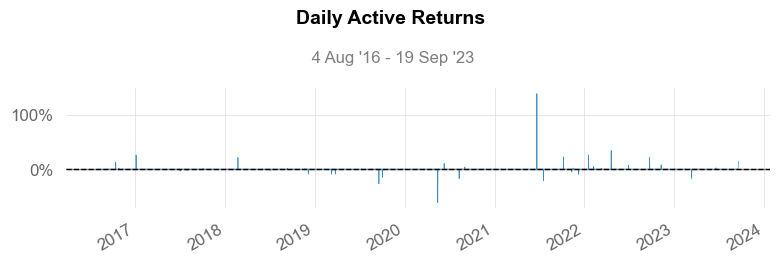

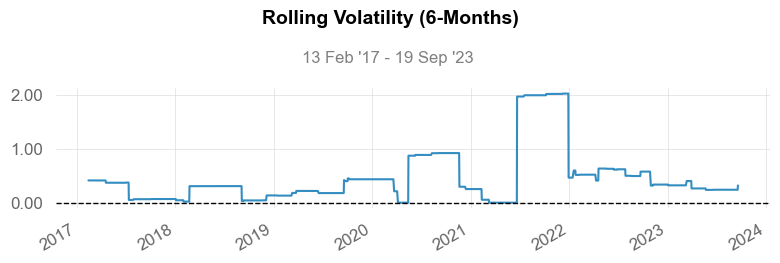

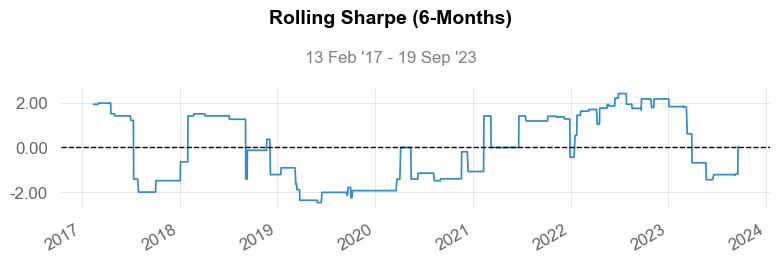

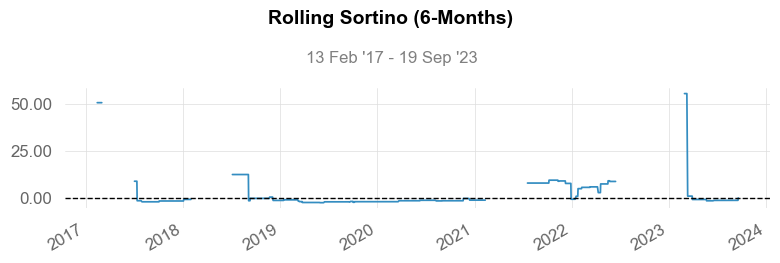

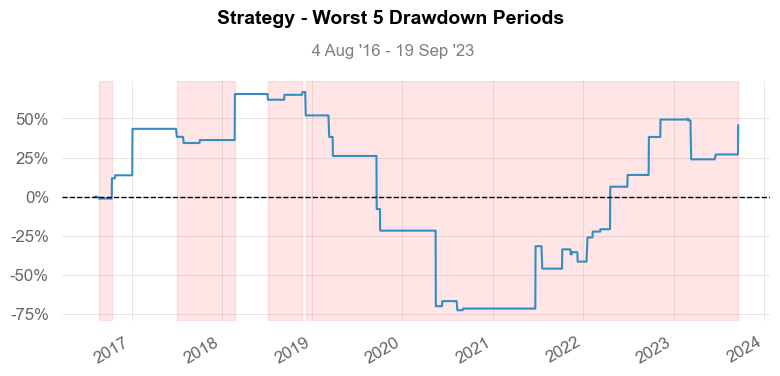

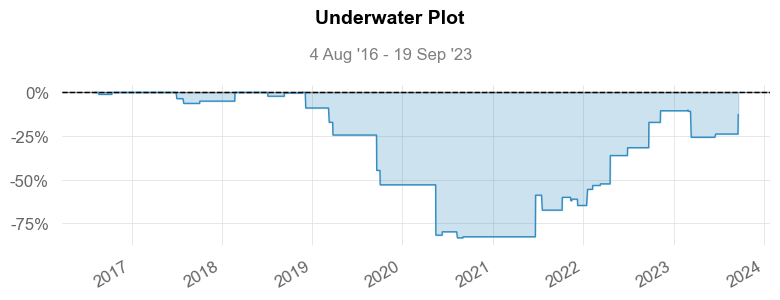

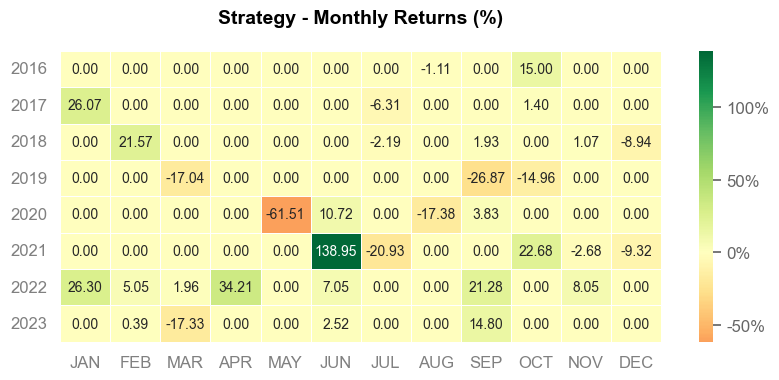

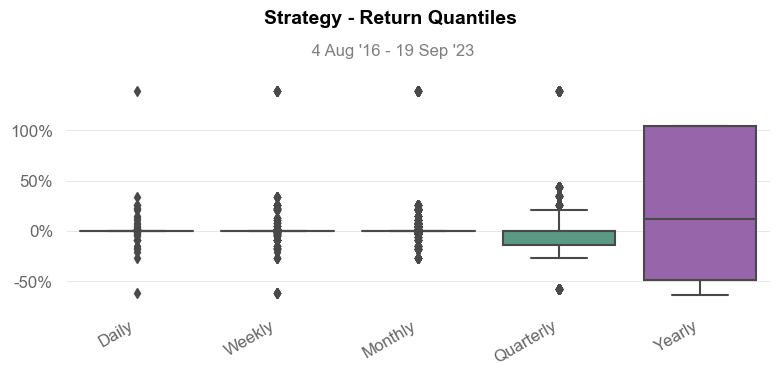

In [158]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=df.index[end_train_index+1:end_val_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

Stable baseline ile Gym SB3 ile Gymnasium